### RNN
    Neste projeto criaremos um modelo de aprendizagem utilizando a RNN para prever o valor futuro da ação da Microsoft. O DataSet para treinamento contêm as açõess de 2012 à 2016, já o Dataset de teste contêm a os valores referente à janeiro de 2017.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

No próximo passo carregamos o dataset de treinamento e selecionamos as colunas que utilizaremos, no caso estamos utilizando as coluna Open

In [2]:
dataset_train = pd.read_csv('ms-training.csv')
training_set = dataset_train.iloc[:, 1:2].values
dataset_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,26.549999,26.959999,26.389999,26.770000,22.504229,64731500
1,2012-01-04,26.820000,27.469999,26.780001,27.400000,23.033840,80516100
2,2012-01-05,27.379999,27.730000,27.290001,27.680000,23.269222,56081400
3,2012-01-06,27.530001,28.190001,27.530001,28.110001,23.630701,99455500
4,2012-01-09,28.049999,28.100000,27.719999,27.740000,23.319664,59706800


Para melhor desempenho do treinamento , é necessário realizar o dimensionamento do conjunto de dados para valores entre 0 e 1.
Para realizar esse dimensionamento utilizaremos MinMaxScaler disponível na biblioteca do Sckit-Learn.

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


Função para obter as features e labels, onde é passado os valores de abertura o ínicio e o final do loop para separação dos valores.
No caso abaixo foi selecionado o valor de 60 a 1258. Onde o loop iniciará no 61º registro, o 'x' receberá os 60 valores anteriores e o y recebe o 61º valor como label.

In [4]:
def get_features_labels(training_scaled, first, last, is_test = False):
    x = []
    y= []
    for i in range(first, last):
        x.append(training_scaled[i-first:i, 0])
        if is_test:
            y.append(training_scaled[i, 0])
    return np.array(x), np.array(y)

X_train, y_train = get_features_labels(training_set_scaled, 60, 1258, True)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

(1198, 60)


Com o uso do Keras montamos nosso modelo utilizando a rede LSTM.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

regressor = Sequential()

regressor.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.25))

regressor.add(LSTM(units = 70, return_sequences = True))
regressor.add(Dropout(0.25))

regressor.add(LSTM(units = 70, return_sequences = True))
regressor.add(Dropout(0.25))

regressor.add(LSTM(units = 70, return_sequences = True))
regressor.add(Dropout(0.25))

regressor.add(LSTM(units = 70))
regressor.add(Dropout(0.25))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1198/1198 [==============================] - 39s 32ms/step - loss: 0.0318
Epoch 2/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0059
Epoch 3/100
1198/1198 [==============================] - 31s 26ms/step - loss: 0.0053
Epoch 4/100
1198/1198 [==============================] - 32s 27ms/step - loss: 0.0055
Epoch 5/100
1198/1198 [==============================] - 36s 30ms/step - loss: 0.0052
Epoch 6/100
1198/1198 [==============================] - 35s 29ms/step - loss: 0.0055
Epoch 7/100
1198/1198 [==============================] - 34s 28ms/step - loss: 0.0042
Epoch 8/100
1198/1198 [==============================] - 34s 29ms/step - loss: 0.0042
Epoch 9/100
1198/1198 [==============================] - 30s 25ms/step - loss

1198/1198 [==============================] - 29s 25ms/step - loss: 0.0014
Epoch 85/100
1198/1198 [==============================] - 27s 23ms/step - loss: 0.0014
Epoch 86/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0017
Epoch 87/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0016
Epoch 88/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0018
Epoch 89/100
1198/1198 [==============================] - 28s 23ms/step - loss: 0.0015
Epoch 90/100
1198/1198 [==============================] - 27s 23ms/step - loss: 0.0015
Epoch 91/100
1198/1198 [==============================] - 32s 27ms/step - loss: 0.0013
Epoch 92/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0015
Epoch 93/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0014
Epoch 94/100
1198/1198 [==============================] - 31s 26ms/step - loss: 0.0013
Epoch 95/100
1198/1198 [==============================] 

Carregamos os valores para teste e fazemos o mesmo pré-processamento que realizamos com os dados de treinamento.

In [6]:
dataset_test = pd.read_csv('ms-testing.csv')
test_set = dataset_test.iloc[:, 1:2].values


Agora vamos preparar nossas entradas de teste. A entrada para cada dia deve conter os preços das ações iniciais dos últimos 60 dias. Isso significa que precisamos abrir os preços das ações para os 19 dias de teste para o mês de janeiro de 2017 e os 60 preços das ações dos últimos 60 dias para o conjunto de treinamento. 

In [7]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test, _ = get_features_labels(inputs,60,79)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

In [8]:
predictions = regressor.predict(X_test)
predictions = sc.inverse_transform(predictions)

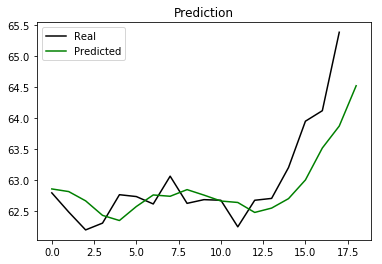

In [9]:
plt.plot(test_set, color = 'black', label = 'Real')
plt.plot(predicted, color = 'green', label = 'Predicted')
plt.title('Prediction')
plt.legend()
plt.show()